In [70]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.stats import chi2

# =========================
# 1. 读取数据
# =========================
df = pd.read_excel('E:\\外包业务\\外2 动静脉内瘘 文章\\1.xlsx')
print(df)

# =========================
# 2. 构建四格表
# =========================
a = df["A意外"]
b = df["B意外"]
c = df["A"] - df["A意外"]
d = df["B"] - df["B意外"]

# =========================
# 3. 连续性校正（只对含 0 的研究）
# =========================
zero_mask = (a == 0) | (b == 0) | (c == 0) | (d == 0)

a[zero_mask] += 0.5
b[zero_mask] += 0.5
c[zero_mask] += 0.5
d[zero_mask] += 0.5

# =========================
# 4. 计算 RR 和 logRR（标准公式）
# =========================
df["RR"] = (a / (a + c)) / (b / (b + d))
df["logRR"] = np.log(df["RR"])

# =========================
# 5. logRR 方差 & 标准误（教科书公式）
# =========================
df["var"] = (1 / a) - (1 / (a + c)) + (1 / b) - (1 / (b + d))
df["se"] = np.sqrt(df["var"])

# =========================
# 6. 固定效应模型
# =========================
w_fixed = 1 / df["var"]
fixed_mean = np.sum(w_fixed * df["logRR"]) / np.sum(w_fixed)

# Q 统计量
Q = np.sum(w_fixed * (df["logRR"] - fixed_mean) ** 2)

# 自由度
k = len(df)
dfree = k - 1

# 固定效应模型的标准误和方差
fixed_se = np.sqrt(1 / np.sum(w_fixed))
fixed_var = 1 / np.sum(w_fixed)

# =========================
# 7. 随机效应模型（DerSimonian–Laird）
# =========================
tau2 = max(
    0,
    (Q - dfree) /
    (np.sum(w_fixed) - np.sum(w_fixed ** 2) / np.sum(w_fixed))
)

w_random = 1 / (df["var"] + tau2)
random_mean = np.sum(w_random * df["logRR"]) / np.sum(w_random)
random_se = np.sqrt(1 / np.sum(w_random))

# =========================
# 8. 合并 RR + 95% CI
# =========================
lower = random_mean - 1.96 * random_se
upper = random_mean + 1.96 * random_se

RR_pooled = np.exp(random_mean)
CI_lower = np.exp(lower)
CI_upper = np.exp(upper)

# =========================
# 9. 异质性 I²
# =========================
I2 = max(0, (Q - dfree) / Q) * 100 if Q > 0 else 0

# =========================
# 9.5 随机 RR 的 Z 值和 P 值
# =========================
Z_value = random_mean / random_se
P_value = 2 * (1 - norm.cdf(abs(Z_value)))

# =========================
# 9.5 计算合并RR的置信区间和p值
# =========================

# 固定效应模型的置信区间和p值
fixed_lower = fixed_mean - 1.96 * fixed_se
fixed_upper = fixed_mean + 1.96 * fixed_se
fixed_RR = np.exp(fixed_mean)
fixed_CI_lower = np.exp(fixed_lower)
fixed_CI_upper = np.exp(fixed_upper)

# 固定效应模型的Z值和P值
fixed_Z = fixed_mean / fixed_se
fixed_P = 2 * (1 - norm.cdf(abs(fixed_Z)))

# =========================
# 9.5 异质性检验的 P 值（Q 检验）
# =========================
P_heterogeneity = 1 - chi2.cdf(Q, dfree)
# =========================
# 10. 单研究 RR + CI
# =========================
df["RR_lower"] = np.exp(df["logRR"] - 1.96 * df["se"])
df["RR_upper"] = np.exp(df["logRR"] + 1.96 * df["se"])
df["RR_value"] = df["RR"]

# 权重（随机效应）
w_random_total = np.sum(w_random)
df["weight_percent"] = (w_random / w_random_total) * 100

# =========================
# 11. 结果输出
# =========================
print("\n" + "=" * 80)
print("Meta分析结果汇总")
print("=" * 80)
print(f"研究数量: {k}")
print(f"固定效应模型合并RR: {fixed_RR:.4f} (95% CI: {fixed_CI_lower:.4f} – {fixed_CI_upper:.4f}), P = {fixed_P:.4g}")
print(f"随机效应模型合并RR: {RR_pooled:.4f} "
      f"(95% CI: {CI_lower:.4f} – {CI_upper:.4f}), "
      f"P = {P_value:.4g}")
print(f"异质性: Q = {Q:.4f}, df = {dfree}, "
      f"I² = {I2:.2f}%, P = {P_heterogeneity:.4g}")
print(f"研究间方差 τ² = {tau2:.6f}")


if I2 > 50:
    print("提示：存在明显异质性（I² > 50%），优先报告随机效应模型结果")
else:
    print("提示：无异质性或低异质性，固定效应模型和随机效应模型结果均可报告")

print("=" * 80)
print(df)


from scipy import stats
import numpy as np

def eggers_test(log_effect, se):
    """
    Egger's regression test for publication bias
    log_effect: logRR / logOR
    se: standard error of log_effect
    """
    # 标准化效应
    SND = log_effect / se          # Standard Normal Deviate
    precision = 1 / se

    # 加常数项（截距）
    X = np.vstack([np.ones(len(precision)), precision]).T

    # OLS 回归
    beta, residuals, rank, s = np.linalg.lstsq(X, SND, rcond=None)

    intercept = beta[0]

    # 计算标准误
    n = len(SND)
    df = n - 2
    y_hat = X @ beta
    residual_var = np.sum((SND - y_hat) ** 2) / df
    cov_beta = residual_var * np.linalg.inv(X.T @ X)
    se_intercept = np.sqrt(cov_beta[0, 0])

    # t 值 & p 值
    t_stat = intercept / se_intercept
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df))

    return intercept, se_intercept, t_stat, p_value
# =========================
# Egger's 检验（≥5 篇才做）
# =========================
if len(df) >= 5:
    intercept, se_i, t_i, p_egger = eggers_test(
        df["logRR"].values,
        df["se"].values
    )

    print("\nEgger's test for publication bias")
    print("-" * 50)
    print(f"Intercept = {intercept:.4f}")
    print(f"SE = {se_i:.4f}")
    print(f"t = {t_i:.3f}")
    print(f"P = {p_egger:.4f}")

    if p_egger < 0.05:
        print("提示：Egger's 检验显示可能存在发表偏倚 (P < 0.05)")
    else:
        print("提示：Egger's 检验未发现明显发表偏倚 (P ≥ 0.05)")
else:
    print("\n研究数量 < 5，不建议进行 Egger's 检验")


                   作者+年份   A  A意外   B  B意外
0              石梅 等 2016  25    8  25    1
1  MacRae JM et al. 2012  70    0  70    3
2               叶婷香 2017  80    3  80    1
3                张爽 2022  60    1  60    0
4                孙畅 2020  45    8  45    1
5              孙琳 等 2025  42    2  32    5
6  Peralta R et al. 2022  56    0  57    0

Meta分析结果汇总
研究数量: 7
固定效应模型合并RR: 1.5980 (95% CI: 0.6805 – 3.7522), P = 0.2818
随机效应模型合并RR: 1.6960 (95% CI: 0.4702 – 6.1176), P = 0.4196
异质性: Q = 12.2286, df = 6, I² = 50.93%, P = 0.05706
研究间方差 τ² = 1.451040
提示：存在明显异质性（I² > 50%），优先报告随机效应模型结果
                   作者+年份   A  A意外   B  B意外        RR     logRR       var  \
0              石梅 等 2016  25  8.0  25  1.0  8.000000  2.079442  1.045000   
1  MacRae JM et al. 2012  70  0.5  70  3.5  0.142857 -1.945910  2.257545   
2               叶婷香 2017  80  3.0  80  1.0  3.000000  1.098612  1.308333   
3                张爽 2022  60  1.5  60  0.5  3.000000  1.098612  2.633880   
4                孙畅 2020  45  8.0  45

C:\Users\Fengye liu\AppData\Local\Temp\ipykernel_13316\3216070686.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a[zero_mask] += 0.5
C:\Users\Fengye liu\AppData\Local\Temp\ipykernel_13316\3216070686.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.5 1.5 0.5]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  a[zero_mask] += 0.5
C:\Users\Fengye liu\AppData\Local\Temp\ipykernel_13316\3216070686.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b[zero_mask] += 0.5
C:\Users\Fengye liu\Ap

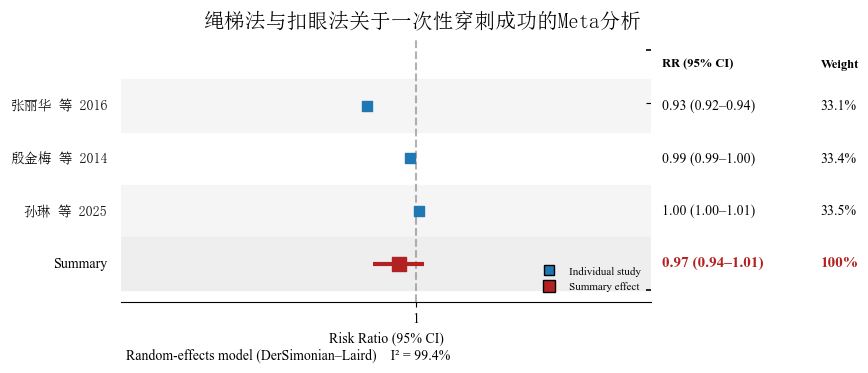

In [62]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import NullLocator, FuncFormatter
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties


# ================= 字体设置（中英混排稳妥方案） =================
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['axes.unicode_minus'] = False


# ================= 数据整理 =================
df = df.copy()

df['study'] = df['作者+年份'].astype(str)

df = df.sort_values('RR_value').reset_index(drop=True)


# ================= 行距 =================
row_step = 0.3
y_pos = np.arange(len(df)) * row_step
summary_y = len(df) * row_step


# ================= ★★★ 关键修改 1：提前算 x 轴范围 ★★★ =================
xmin = min(df['RR_lower'].min(), CI_lower) * 0.7
xmax = max(df['RR_upper'].max(), CI_upper) * 1.4


# ================= 画布 =================
fig, ax = plt.subplots(figsize=(8.5, row_step * len(df) + 3))

point_color = '#1f77b4'
summary_color = '#b22222'


# ================= 背景交替 =================
for i, y in enumerate(y_pos):
    if i % 2 == 0:
        ax.axhspan(y - row_step/2, y + row_step/2,
                   color='#f5f5f5', zorder=0)

ax.axhspan(summary_y - row_step/2, summary_y + row_step/2,
           color='#eeeeee', zorder=0)


# ================= CI & 点 =================
ax.hlines(y_pos, df['RR_lower'], df['RR_upper'],
          color=point_color, linewidth=1.6, zorder=2)

ax.scatter(df['RR_value'], y_pos,
           marker='s', s=45,
           color=point_color, zorder=3)


# ================= 汇总效应 =================
ax.hlines(summary_y, CI_lower, CI_upper,
          color=summary_color, linewidth=3, zorder=3)

ax.scatter(RR_pooled, summary_y,
           marker='s', s=90,
           color=summary_color, zorder=4)


# ================= 左侧研究名（中文，稳定） =================
for i, label in enumerate(df['study']):
    ax.text(xmin * 0.98, y_pos[i], label,
            ha='right', va='center',
            fontproperties=font_cn, fontsize=10)

ax.text(xmin * 0.98, summary_y, 'Summary',
        ha='right', va='center',
        fontproperties=font_en, fontsize=10, fontweight='bold')

ax.tick_params(axis='y', labelleft=False)
ax.invert_yaxis()


# ================= x 轴设置 =================
ax.set_xscale('log')
ax.set_xlim(xmin, xmax)
ax.set_xlabel('Risk Ratio (95% CI)')

x_ticks = [0.1, 0.25, 0.5, 1, 2, 4, 8, 10]
ax.set_xticks([x for x in x_ticks if xmin < x < xmax])
ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, _: f'{x:g}'))
ax.xaxis.set_minor_locator(NullLocator())

ax.axvline(1, linestyle='--', color='gray', alpha=0.6)

ax.spines[['top', 'right', 'left']].set_visible(False)
ax.tick_params(axis='y', length=0)


# ================= I² =================
ax.text(0.01, -0.22,
        f'Random-effects model (DerSimonian–Laird)    I² = {I2:.1f}%',
        transform=ax.transAxes, fontsize=10)


# ================= 右侧表格（锁死坐标系） =================
fig.subplots_adjust(right=0.65)

rr_col_x = 1.02
wt_col_x = 1.32

for i, row in df.iterrows():
    ax.text(rr_col_x, y_pos[i],
            f"{row['RR_value']:.2f} ({row['RR_lower']:.2f}–{row['RR_upper']:.2f})",
            va='center', ha='left', fontsize=10,
            transform=ax.get_yaxis_transform())

    ax.text(wt_col_x, y_pos[i],
            f"{row['weight_percent']:.1f}%",
            va='center', ha='left', fontsize=10,
            transform=ax.get_yaxis_transform())


# ================= 三线表（锁死，不进图内） =================
header_y = y_pos[0] - 0.55 * row_step
table_left = 0.99
table_right = 1.7

ax.hlines(header_y - row_step/2,
          table_left, table_right,
          transform=ax.get_yaxis_transform(),
          color='black', linewidth=1.2)

ax.hlines(header_y + row_step/2,
          table_left, table_right,
          transform=ax.get_yaxis_transform(),
          color='black', linewidth=0.8)

ax.hlines(summary_y + row_step/2,
          table_left, table_right,
          transform=ax.get_yaxis_transform(),
          color='black', linewidth=1.2)

ax.text(rr_col_x, header_y - 0.1,
        "RR (95% CI)",
        ha='left', va='top',
        fontsize=9, fontweight='bold',
        transform=ax.get_yaxis_transform())

ax.text(wt_col_x, header_y - 0.1,
        "Weight",
        ha='left', va='top',
        fontsize=9, fontweight='bold',
        transform=ax.get_yaxis_transform())


# ================= Summary 行 =================
ax.text(rr_col_x, summary_y,
        f"{RR_pooled:.2f} ({CI_lower:.2f}–{CI_upper:.2f})",
        va='center', ha='left',
        fontsize=11, fontweight='bold',
        color=summary_color,
        transform=ax.get_yaxis_transform())

ax.text(wt_col_x, summary_y,
        "100%",
        va='center', ha='left',
        fontsize=11, fontweight='bold',
        color=summary_color,
        transform=ax.get_yaxis_transform())


# ================= 标题 & 图例 =================
fig.text(0.5, 0.96,
         '绳梯法与扣眼法关于一次性穿刺成功的Meta分析',
         ha='center', va='center',
         fontproperties=font_cn,
         fontsize=15, fontweight='bold')

legend_elements = [
    Line2D([0], [0], marker='s', color='none',
           markerfacecolor=point_color, markersize=7,
           label='Individual study'),
    Line2D([0], [0], marker='s', color='none',
           markerfacecolor=summary_color, markersize=9,
           label='Summary effect')
]

ax.legend(handles=legend_elements,
          frameon=False, fontsize=8,
          loc='lower right')

plt.tight_layout(rect=[0, 0.02, 1, 0.95])
plt.show()


In [63]:
# 保存为矢量图（PDF，推荐）
output_path = r'E:\外包业务\外2 动静脉内瘘 文章\尸块\图3D.pdf'
fig.savefig(
    output_path,
    format='pdf',
    bbox_inches='tight',
    facecolor='white'
)

print(f"森林图已保存为矢量PDF: {output_path}")


森林图已保存为矢量PDF: E:\外包业务\外2 动静脉内瘘 文章\尸块\图3D.pdf


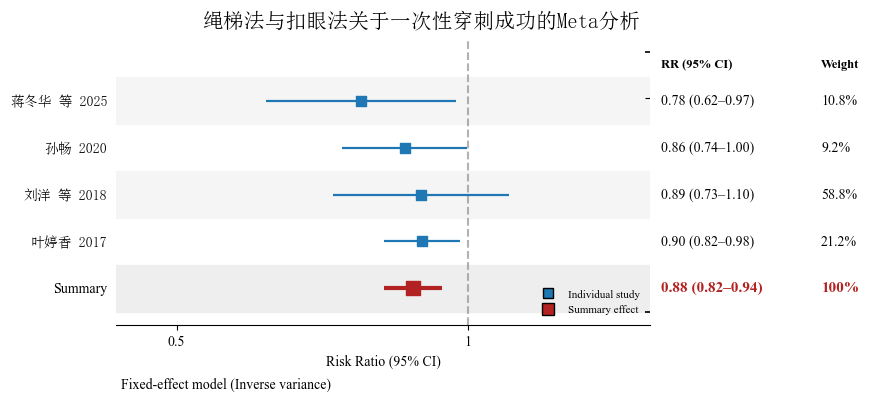

In [53]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import NullLocator, FuncFormatter
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties
import matplotlib as mpl


# ================= 字体设置（保持与你一致） =================
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['axes.unicode_minus'] = False


# ================= 数据整理 =================
df = df.copy()
df['study'] = df['作者+年份'].astype(str)

df = df.sort_values('RR_value').reset_index(drop=True)


# ================= 行距 =================
row_step = 0.3
y_pos = np.arange(len(df)) * row_step
summary_y = len(df) * row_step


# ================= ★★★ x 轴范围（用 fixed CI）★★★ =================
xmin = min(df['RR_lower'].min(), fixed_CI_lower) * 0.7
xmax = max(df['RR_upper'].max(), fixed_CI_upper) * 1.4


# ================= 画布 =================
fig, ax = plt.subplots(figsize=(8.5, row_step * len(df) + 3))

point_color = '#1f77b4'
summary_color = '#b22222'


# ================= 背景交替 =================
for i, y in enumerate(y_pos):
    if i % 2 == 0:
        ax.axhspan(y - row_step/2, y + row_step/2,
                   color='#f5f5f5', zorder=0)

ax.axhspan(summary_y - row_step/2, summary_y + row_step/2,
           color='#eeeeee', zorder=0)


# ================= 单研究 CI & 点 =================
ax.hlines(y_pos, df['RR_lower'], df['RR_upper'],
          color=point_color, linewidth=1.6, zorder=2)

ax.scatter(df['RR_value'], y_pos,
           marker='s', s=45,
           color=point_color, zorder=3)


# ================= 固定效应 汇总效应 =================
ax.hlines(summary_y, fixed_CI_lower, fixed_CI_upper,
          color=summary_color, linewidth=3, zorder=3)

ax.scatter(fixed_RR, summary_y,
           marker='s', s=90,
           color=summary_color, zorder=4)


# ================= 左侧研究名 =================
for i, label in enumerate(df['study']):
    ax.text(xmin * 0.98, y_pos[i], label,
            ha='right', va='center',
            fontproperties=font_cn, fontsize=10)

ax.text(xmin * 0.98, summary_y, 'Summary',
        ha='right', va='center',
        fontproperties=font_en, fontsize=10, fontweight='bold')

ax.tick_params(axis='y', labelleft=False)
ax.invert_yaxis()


# ================= x 轴 =================
ax.set_xscale('log')
ax.set_xlim(xmin, xmax)
ax.set_xlabel('Risk Ratio (95% CI)')

x_ticks = [0.1, 0.25, 0.5, 1, 2, 4, 8, 10]
ax.set_xticks([x for x in x_ticks if xmin < x < xmax])
ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, _: f'{x:g}'))
ax.xaxis.set_minor_locator(NullLocator())

ax.axvline(1, linestyle='--', color='gray', alpha=0.6)

ax.spines[['top', 'right', 'left']].set_visible(False)
ax.tick_params(axis='y', length=0)


# ================= 固定效应说明 =================
ax.text(0.01, -0.22,
        'Fixed-effect model (Inverse variance)',
        transform=ax.transAxes, fontsize=10)


# ================= 右侧表格 =================
fig.subplots_adjust(right=0.65)

rr_col_x = 1.02
wt_col_x = 1.32

# 固定效应权重
df['weight_fixed'] = (w_fixed / np.sum(w_fixed)) * 100

for i, row in df.iterrows():
    ax.text(rr_col_x, y_pos[i],
            f"{row['RR_value']:.2f} ({row['RR_lower']:.2f}–{row['RR_upper']:.2f})",
            va='center', ha='left', fontsize=10,
            transform=ax.get_yaxis_transform())

    ax.text(wt_col_x, y_pos[i],
            f"{row['weight_fixed']:.1f}%",
            va='center', ha='left', fontsize=10,
            transform=ax.get_yaxis_transform())


# ================= 三线表 =================
header_y = y_pos[0] - 0.55 * row_step
table_left = 0.99
table_right = 1.7

ax.hlines(header_y - row_step/2,
          table_left, table_right,
          transform=ax.get_yaxis_transform(),
          color='black', linewidth=1.2)

ax.hlines(header_y + row_step/2,
          table_left, table_right,
          transform=ax.get_yaxis_transform(),
          color='black', linewidth=0.8)

ax.hlines(summary_y + row_step/2,
          table_left, table_right,
          transform=ax.get_yaxis_transform(),
          color='black', linewidth=1.2)

ax.text(rr_col_x, header_y - 0.1,
        "RR (95% CI)",
        ha='left', va='top',
        fontsize=9, fontweight='bold',
        transform=ax.get_yaxis_transform())

ax.text(wt_col_x, header_y - 0.1,
        "Weight",
        ha='left', va='top',
        fontsize=9, fontweight='bold',
        transform=ax.get_yaxis_transform())


# ================= Summary 行 =================
ax.text(rr_col_x, summary_y,
        f"{fixed_RR:.2f} ({fixed_CI_lower:.2f}–{fixed_CI_upper:.2f})",
        va='center', ha='left',
        fontsize=11, fontweight='bold',
        color=summary_color,
        transform=ax.get_yaxis_transform())

ax.text(wt_col_x, summary_y,
        "100%",
        va='center', ha='left',
        fontsize=11, fontweight='bold',
        color=summary_color,
        transform=ax.get_yaxis_transform())


# ================= 标题 & 图例 =================
fig.text(0.5, 0.96,
         '绳梯法与扣眼法关于一次性穿刺成功的Meta分析',
         ha='center', va='center',
         fontproperties=font_cn,
         fontsize=15, fontweight='bold')

legend_elements = [
    Line2D([0], [0], marker='s', color='none',
           markerfacecolor=point_color, markersize=7,
           label='Individual study'),
    Line2D([0], [0], marker='s', color='none',
           markerfacecolor=summary_color, markersize=9,
           label='Summary effect')
]

ax.legend(handles=legend_elements,
          frameon=False, fontsize=8,
          loc='lower right')

plt.tight_layout(rect=[0, 0.02, 1, 0.95])
plt.show()
